In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PF import *


In [2]:
# Set noise seed
noise_seed = np.random.randint(10000)
print(noise_seed)
np.random.seed(seed=noise_seed)

#8933

# -------------------- Initialize the parameters -------------------- 
Nx  = 5    # No. of variables
Nr  = 2*Nx  # No. of neurons
Nh  = 1 + Nx  # No. of external input variables

T   = 10000  # No. of time steps
Th  = 2     # No. of time steps for which h is the same
Ns  = 1     # No. of batches
lam = np.array([0.25])  # low pass filtering constant for the TAP dynamics

nltype = 'sigmoid' # external nonlinearity in TAP dynamics

# Noise covariances 
Qpr = 1e-5*np.eye(Nx) # process noise
Qobs = 4e-4*np.eye(Nr) # measurement noise

# True TAP model parameters
Jtype = 'nonferr';
sc_J    = 1; # 1 : self coupling ON, 0: OFF
if Nx <= 4:
    sp_J = 0.1 # sparsity in J
else:
    sp_J = 0.3
    
J = 3*Create_J(Nx, sp_J, 'Jtype', sc_J) # Coupling matrix
G = np.array([2,4,-4,-8,8])   
U = np.random.randn(Nr,Nx) # embedding matrix
V = np.linalg.svd(np.random.randn(Nx,Nh), full_matrices=False)[2] # input embedding matrix

# concatenate the parameters
theta = np.concatenate([lam, G, JMatToVec(J), U.flatten('F'), V.flatten('F') ])

2897


In [3]:
# ---------- Generate the latent dynamics and observations ----------------

# Inputs parameters
gh = 25/np.sqrt(Nx) # gain for inputs h
hMatFull = np.zeros([Nh,T,Ns]) # inputs h

# Initial conditions for latent dynamics
x0Full = np.random.rand(Nx,Ns) # initial x

xMatFull = np.zeros([Nx,T+1,Ns])
rMatFull = np.zeros([Nr,T,Ns])

b = signal.hamming(5,sym=True) 
b = b/sum(b)

for s in range(Ns):
    hMatFull[:,:,s] = signal.filtfilt(b,1,generateBroadH(Nh,T,Th,gh))
    xMatFull[:,:,s], rMatFull[:,:,s] = runTAP(x0Full[:,s], hMatFull[:,:,s], Qpr, Qobs, theta, nltype)
    
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(xMatFull[0,:,:].flatten(), xMatFull[1,:,:].flatten(), xMatFull[2,:,:].flatten(), c='b', marker='.')
# plt.show()

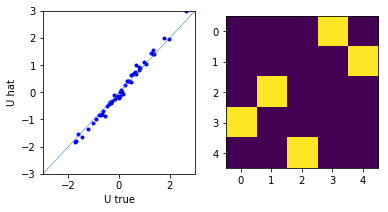

In [4]:
# ------------- Run ICA to get initial estimate of the embedding --------------
U_1 = UhatICA(np.reshape(rMatFull,[Nr,T*Ns],order='F').T, Nx, U)[0]

# P = np.zeros([Nx,Nx])
# for i in range(Nx):
#     err = np.sum((np.expand_dims(U_1[:,i],1) - U)**2, axis=0)
#     P[i,np.argmin(err)] = 1
    
P = np.zeros([Nx,Nx])

for i in range(Nx):
    err = np.sum((np.expand_dims(U_1[:,i],1) - U)**2, axis=0)
    idx = np.argsort(err)
      
    if i == 0:
        taken = np.array([idx[0]])
        P[i,idx[0]] = 1
    else:
        k = 0
        while np.intersect1d(idx[k], taken).shape[0] != 0:
            k += 1
            
        P[i,idx[k]] = 1
        taken = np.append(taken, idx[k])


fig, ax = plt.subplots(1,2,figsize=(6,3))

ax[0].plot(U.flatten(),np.dot(U_1,P).flatten(),'b.')
r = np.ceil(np.max(np.abs(U)))
ax[0].plot([-r,r],[-r,r],Linewidth=0.5)
ax[0].axis([-r,r,-r,r])
ax[0].set(xlabel='U true', ylabel='U hat')
ax[1].imshow(P)
plt.show()

In [5]:
# Pick T such that we have a total of 500 samples
TTotal = 500
T = TTotal//Ns

rMatFull = rMatFull[:,0:T,:]
hMatFull = hMatFull[:,0:T,:]
xMatFull = xMatFull[:,0:T+1,:]


# ---------  Run the particle filter with true values of (U, J, G) --------
K = 100

x_truedec = np.zeros([Nx,T+1,Ns])
P_truedec = np.zeros([Nx,K,T+1,Ns])
r_truedec = np.zeros([Nr,T,Ns])
W_truedec = np.zeros([K,Ns])
LL        = np.zeros([Ns]) # Log likelihood 

for s in range(Ns):
    LL[s],x_truedec[:,:,s], P_truedec[:,:,:,s], W_truedec[:,s] = particlefilter(rMatFull[:,:,s], hMatFull[:,:,s], K, Qpr, Qobs, theta, nltype)
    r_truedec[:,:,s] = np.dot(U,x_truedec[:,1:,s])


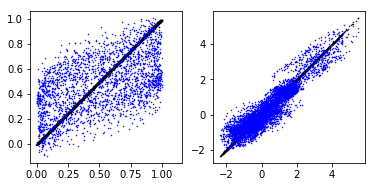

In [6]:
# ----------- Now we try to learn the parameters from data using PF-EM ----

lam_1 = np.array([0.25])
J_1 = Create_J(Nx, sp_J, 'Jtype', sc_J) # Coupling matrix
G_1 = 0.1*np.random.randn(5)   
V_1 = np.linalg.svd(np.random.randn(Nx,Nh), full_matrices=False)[2] # input embedding matrix


x_1 = np.zeros([Nx,T+1,Ns])
r_1 = np.zeros([Nr,T,Ns])
P_1 = np.zeros([Nx,K,T+1,Ns])
W_1 = np.zeros([K,Ns])
L_1 = np.zeros([Ns])

theta_1 = np.concatenate([lam_1, G_1, JMatToVec(J_1), U_1.flatten('F'), V_1.flatten('F') ])


for s in range(Ns):
    L_1[s],x_1[:,:,s], P_1[:,:,:,s], W_1[:,s] = particlefilter(rMatFull[:,:,s], hMatFull[:,:,s], K, Qpr, Qobs, theta_1, nltype)
    r_1[:,:,s] = np.dot(U_1,x_1[:,1:,s])
    
st = 6 #

plt.subplot(1,2,1)
plt.plot(xMatFull[:,st:,:].flatten(),x_truedec[:,st:,:].flatten(),'k.',markersize=1)
plt.plot(xMatFull[:,st:,:].flatten(), np.dot(P.T,np.reshape(x_1[:,st:,:],[Nx,Ns*(T+1-st)])).flatten(),'b.',markersize=1)
plt.axis('square')
plt.subplot(1,2,2)
plt.plot(rMatFull[:,st:,:].flatten(),r_truedec[:,st:,:].flatten(),'k.',markersize=1)
plt.plot(rMatFull[:,st:,:].flatten(),r_1[:,st:,:].flatten(),'b.',markersize=1)
plt.axis('square')
plt.show()


xinit = x_1
rinit = r_1

Jinit = J_1
Ginit = G_1
Uinit = U_1
Vinit = V_1
lam_init = lam_1

del x_truedec, r_truedec, P_truedec, W_truedec

In [7]:
# Running the EM algorithm

# Initialize the batch
idx     = np.random.randint(Ns)
rB      = rMatFull[:,:,idx] # pick the observations for the mini batch
hB      = hMatFull[:,:,idx]
P_B     = P_1[:,:,:,idx]
W_B     = W_1[:,idx]

EMIters = 50
LMat   = np.zeros([EMIters])

computegrad = np.array([1,1,0,1,0],dtype=int)


for iterem in range(EMIters):
    
    if iterem == EMIters//5:
        computegrad = [1, 1, 1, 1, 0]

    if iterem % 50 == 49:
        print('iterem =', iterem + 1)  
    
    MStep = optimize.minimize(NegLL, theta_1, args = (rB, hB, P_B, W_B, Qpr, Qobs, nltype, computegrad), method='BFGS', jac = NegLL_D, options={'disp': False,'maxiter':20})
    theta_1 = MStep.x
        
    # Pick a new batch and run the particle filter with the updated parameters
    
    idx     = np.random.randint(Ns)
    rB      = rMatFull[:,:,idx] # pick the observations for the mini batch
    hB      = hMatFull[:,:,idx]
    
    LMat[iterem], x_B, P_B, W_B = particlefilter(rB, hB, K, Qpr, Qobs, theta_1, nltype)
    

# Extract parameters
lam_1, G_1, J_1, U_1, V_1 = extractParams(theta_1, 5, Nx, Nh, Nr)

# Run the PF with new parameters on all the batches
for s in range(Ns):
    L_1[s],x_1[:,:,s], P_1[:,:,:,s], W_1[:,s] = particlefilter(rMatFull[:,:,s], hMatFull[:,:,s], K, Qpr, Qobs, theta_1, nltype)
    r_1[:,:,s] = np.dot(U_1,x_1[:,1:,s])

iterem = 50


Ghat = [ 1.65310205  0.70609676 -0.85800289 -1.5368338   1.52212342]


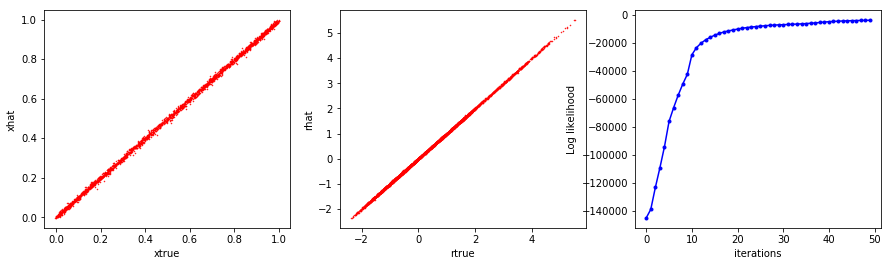

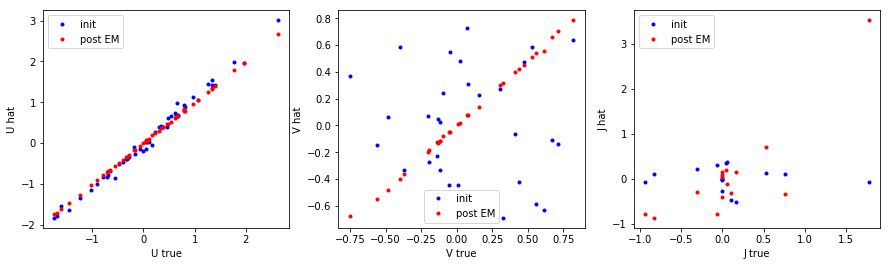

In [8]:
# Plotting results

print('Ghat =', G_1)

fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0].plot(xMatFull[:,st:,:].flatten(), np.dot(P.T,np.reshape(x_1[:,st:,:],[Nx,Ns*(T+1-st)])).flatten(),'r.',markersize=1)
ax[0].set(xlabel='xtrue', ylabel='xhat')
ax[1].plot(rMatFull[:,st:,:].flatten(),r_1[:,st:,:].flatten(),'r.',markersize=1)
ax[1].set(xlabel='rtrue', ylabel='rhat')
ax[2].plot(np.arange(EMIters),LMat,'b.-')
ax[2].set(xlabel='iterations', ylabel='Log likelihood')
plt.show()

Jhat = J_1*0
Jinit_s = Jinit*0 # shuffle Jinit also
x_idx = np.dot(P.T,np.arange(Nx))

for ii in range(Nx):
    for jj in range(Nx):
        Jhat[ii,jj] = J_1[np.int(x_idx[ii]),np.int(x_idx[jj])]
        Jinit_s[ii,jj] = Jinit[np.int(x_idx[ii]),np.int(x_idx[jj])]
                          

fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(U.flatten(),np.dot(Uinit,P).flatten(),'b.')
ax[0].plot(U.flatten(),np.dot(U_1,P).flatten(),'r.')
ax[0].set(xlabel='U true', ylabel='U hat')
ax[0].legend(['init', 'post EM'])

ax[1].plot(V.flatten(),np.dot(P.T,Vinit).flatten(),'b.')
ax[1].plot(V.flatten(),np.dot(P.T,V_1).flatten(),'r.')
ax[1].set(xlabel='V true', ylabel='V hat')
ax[1].legend(['init', 'post EM'])

ax[2].plot(JMatToVec(J),JMatToVec(Jinit_s),'b.')
ax[2].plot(JMatToVec(J),JMatToVec(Jhat),'r.')
ax[2].set(xlabel='J true', ylabel='J hat')
ax[2].legend(['init', 'post EM'])
plt.show()

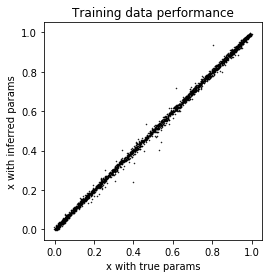

In [9]:
# run dynamics with new set of parameters on training inputs and compare
xMatFull_1 = np.zeros([Nx,T+1,Ns])
for s in range(Ns):
    xMatFull_1[:,:,s] = runTAP(x0Full[:,s], hMatFull[:,:,s], Qpr, Qobs, theta_1, nltype)[0]

st = 5
plt.plot(xMatFull[:,st:,:].flatten(), np.dot(P.T,np.reshape(xMatFull_1[:,st:,:],[Nx,Ns*(T-st+1)])).flatten(),'k.',markersize=1)
plt.title('Training data performance')
plt.xlabel('x with true params')
plt.ylabel('x with inferred params')
plt.axis('square')
plt.show()

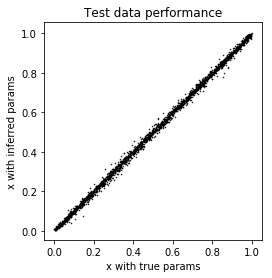

In [10]:
# run dynamics with new set of parameters on test inputs and compare
xtest_true = np.zeros([Nx,T+1,Ns])
xtest_inf = np.zeros([Nx,T+1,Ns])

x0test = np.random.rand(Nx,Ns) # initial x for test data

# test inputs
hMatFull_test = np.zeros([Nh,T,Ns]) # inputs h

for s in range(Ns):
    hMatFull_test[:,:,s] = signal.filtfilt(b,1,generateBroadH(Nh,T,Th,gh))
    xtest_true[:,:,s] = runTAP(x0test[:,s], hMatFull_test[:,:,s], Qpr, Qobs, theta, nltype)[0]
    xtest_inf[:,:,s] = runTAP(x0test[:,s], hMatFull_test[:,:,s], Qpr, Qobs, theta_1, nltype)[0]

st = 5
plt.plot(xtest_true[:,st:,:].flatten(), np.dot(P.T,np.reshape(xtest_inf[:,st:,:],[Nx,Ns*(T-st+1)])).flatten(),'k.',markersize=1)
plt.title('Test data performance')
plt.xlabel('x with true params')
plt.ylabel('x with inferred params')
plt.axis('square')
plt.show()